In [1]:
using Comrade # Import Comrade
using Pyehtim # Load eht-imaging (used for data io)
using PythonPlot #Improt Python Plotting with Matplotlib

    CondaPkg Found dependencies: /home/ptiede/.julia/packages/PythonCall/1f5yE/CondaPkg.toml
    CondaPkg Found dependencies: /home/ptiede/.julia/packages/Pyehtim/YyZzM/CondaPkg.toml
    CondaPkg Resolving changes
             - matplotlib
    CondaPkg Removing packages
             │ /home/ptiede/.julia/artifacts/a7fe6379eb776b1ec5b4ee1ddb8da76446d3f735/bin/micromamba
             │ -r /home/ptiede/.julia/scratchspaces/0b3b1443-0f03-428d-bdfb-f27f9c1191ea/root
             │ remove
             │ -y
             │ -p /home/ptiede/Research/ComradeTutorial/.CondaPkg/env
             └ matplotlib



                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Transaction

  Prefix: /home/ptiede/Research/ComradeTutorial/.CondaPkg/env

  Removing specs:

   - matplotlib


  Package                           Version  Build               Channel           Size
─────────────────────────────────────────────────────────────────────────────────────────
  Remove:
─────────────────────────────────────────────────────────────────────────────────────────

  - alsa-lib                          1.2.8  h166bdaf_0          conda-forge     Cached
  - attr                              2.5.1  h166bdaf_1          conda-forge     Cached
  - brotli                            1.0.9  h166bdaf_8          conda-forge     Cached
  - brotli-bin                        1.0.9  h166bdaf_8          cond


Transaction starting
Unlinking matplotlib-3.7.1-py310hff52083_0
Unlinking tornado-6.3.2-py310h2372a71_0
Unlinking pyqt-5.15.7-py310hab646b1_3
Unlinking matplotlib-base-3.7.1-py310he60537e_0
Unlinking qt-main-5.15.8-h01ceb2d_13
Unlinking pyqt5-sip-12.11.0-py310heca2aa9_3
Unlinking pyparsing-3.1.0-pyhd8ed1ab_0
Unlinking pillow-9.5.0-py310h582fbeb_1
Unlinking kiwisolver-1.4.4-py310hbf28c38_1
Unlinking fonttools-4.40.0-py310h2372a71_0
Unlinking cycler-0.11.0-pyhd8ed1ab_0
Unlinking contourpy-1.1.0-py310hd41b1e2_0
Unlinking certifi-2023.5.7-pyhd8ed1ab_0
Unlinking xorg-xf86vidmodeproto-2.3.1-h7f98852_1002
Unlinking xcb-util-wm-0.4.1-h8ee46fc_1
Unlinking xcb-util-renderutil-0.3.9-hd590300_1
Unlinking xcb-util-keysyms-0.4.0-h8ee46fc_1
Unlinking xcb-util-image-0.4.0-h8ee46fc_1
Unlinking pulseaudio-client-16.1-hb77b528_4
Unlinking nss-3.89-he45b914_0
Unlinking mysql-libs-8.0.33-hca2cd23_0
Unlinking libxkbcommon-1.5.0-h5d7e998_3
Unlinking libpq-15.3-hbcd7760_1
Unlinking libevent-2.1.12-hf998b51_1

    CondaPkg Installing packages
             │ /home/ptiede/.julia/artifacts/a7fe6379eb776b1ec5b4ee1ddb8da76446d3f735/bin/micromamba
             │ -r /home/ptiede/.julia/scratchspaces/0b3b1443-0f03-428d-bdfb-f27f9c1191ea/root
             │ install
             │ -y
             │ -p /home/ptiede/Research/ComradeTutorial/.CondaPkg/env
             │ --override-channels
             │ --no-channel-priority
             │ libstdcxx-ng[version='>=3.4,<13.0',channel='conda-forge']
             │ numpy[version='<=1.23']
             │ pandas[version='<2']
             │ pip[version='>=22.0.0']
             │ python[version='>=3.7,<4',channel='conda-forge',build='*cpython*']
             │ python[version='>=3.6,<=3.10']
             └ -c conda-forge



                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Transaction

  Prefix: /home/ptiede/Research/ComradeTutorial/.CondaPkg/env

  Updating specs:

   - conda-forge::libstdcxx-ng[version='>=3.4,<13.0']
   - numpy[version='<=1.23']
   - pandas[version='<2']
   - pip[version='>=22.0.0']
   - conda-forge::python[version='>=3.7,<4',build=*cpython*]
   - python[version='>=3.6,<=3.10']


  Package         Version  Build               Channel                    Size
────────────────────────────────────────────────────────────────────────────────
  Change:
──────────────────────────────────────────────────────────────────────────────

    CondaPkg Installing Pip packages
             │ /home/ptiede/Research/ComradeTutorial/.CondaPkg/env/bin/pip
             │ install
             └ ehtim


  Using cached pyparsing-3.1.0-py3-none-any.whl (102 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)


LoadError: ArgumentError: Package PythonPlot not found in current path.
- Run `import Pkg; Pkg.add("PythonPlot")` to install the PythonPlot package.

In [2]:
using StableRNGs
rng = StableRNG(42)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000055)

In [3]:
obs = ehtim.obsdata.load_uvfits(joinpath(dirname(pathof(Comrade)), "..", "examples", "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))
obs = Pyehtim.scan_average(obs.flag_uvdist(uv_min=0.1e9))
typeof(obs)

[ Info: Before homogenizing we have 25 unique times
[ Info: After homogenizing we have 25 unique times


Py

In [4]:
dlcamp, dcphase = extract_table(obs, LogClosureAmplitudes(;snrcut=3), ClosurePhases(;snrcut=3))

/home/ptiede/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptiede/.local/lib/python3.10/site-packages/ehtim/obsdata.py:589: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)
/home/ptiede/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptiede/.local/lib/python3.10/site-packages/ehtim/obsdata.py:589: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

(EHTObservation{Float64,Comrade.EHTLogClosureAmplitudeDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 94
, EHTObservation{Float64,Comrade.EHTClosurePhaseDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 119
)

In [5]:
function model(θ)
    (;radius, width, α, β, f, σG, τG, ξG, xG, yG) = θ
    ring = f*smoothed(stretched(MRing((α,), (β,)), radius, radius), width)
    g = (1-f)*shifted(rotated(stretched(Gaussian(), σG, σG*(1+τG)), ξG), xG, yG)
    return ring + g
end

model (generic function with 1 method)

In [6]:
lklhd = RadioLikelihood(model, dlcamp, dcphase)

RadioLikelihood
	Number of data products: 2


In [7]:
using Distributions, DistributionsAD
prior = (
        radius = Uniform(μas2rad(10.0), μas2rad(30.0)),
        width = Uniform(μas2rad(1.0), μas2rad(10.0)),
        α = Uniform(-0.5, 0.5),
        β = Uniform(-0.5, 0.5),
        f = Uniform(0.0, 1.0),
        σG = Uniform(μas2rad(1.0), μas2rad(40.0)),
        τG = Uniform(0.0, 0.75),
        ξG = Uniform(0.0, 1π),
        xG = Uniform(-μas2rad(80.0), μas2rad(80.0)),
        yG = Uniform(-μas2rad(80.0), μas2rad(80.0))
)

(radius = Uniform{Float64}(a=4.84813681109536e-11, b=1.454441043328608e-10), width = Uniform{Float64}(a=4.84813681109536e-12, b=4.84813681109536e-11), α = Uniform{Float64}(a=-0.5, b=0.5), β = Uniform{Float64}(a=-0.5, b=0.5), f = Uniform{Float64}(a=0.0, b=1.0), σG = Uniform{Float64}(a=4.84813681109536e-12, b=1.939254724438144e-10), τG = Uniform{Float64}(a=0.0, b=0.75), ξG = Uniform{Float64}(a=0.0, b=3.141592653589793), xG = Uniform{Float64}(a=-3.878509448876288e-10, b=3.878509448876288e-10), yG = Uniform{Float64}(a=-3.878509448876288e-10, b=3.878509448876288e-10))

In [9]:
post = Posterior(lklhd, prior);

In [10]:
logdensityof(post, (radius = μas2rad(20.0),
                  width = μas2rad(10.0),
                  α = 0.3,
                  β = 0.3,
                  f = 0.6,
                  σG = μas2rad(20.0),
                  τG = 0.1,
                  ξG = 0.5,
                  xG = 0.0,
                  yG = 0.0))

-32988.5119925049

In [11]:
cpost = ascube(post) # Now we want to simplify our representation of the model

Comrade.TransformedPosterior{Posterior{RadioLikelihood{typeof(model), Nothing, Tuple{Comrade.EHTObservation{Float64, Comrade.EHTLogClosureAmplitudeDatum{Float64}, StructArrays.StructVector{Comrade.EHTLogClosureAmplitudeDatum{Float64}, NamedTuple{(:measurement, :error, :U1, :V1, :U2, :V2, :U3, :V3, :U4, :V4, :T, :F, :quadrangle), Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{NTuple{4, Symbol}}}}, Int64}, Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Tab

In [12]:
fpost = asflat(post)

Comrade.TransformedPosterior{Posterior{RadioLikelihood{typeof(model), Nothing, Tuple{Comrade.EHTObservation{Float64, Comrade.EHTLogClosureAmplitudeDatum{Float64}, StructArrays.StructVector{Comrade.EHTLogClosureAmplitudeDatum{Float64}, NamedTuple{(:measurement, :error, :U1, :V1, :U2, :V2, :U3, :V3, :U4, :V4, :T, :F, :quadrangle), Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{NTuple{4, Symbol}}}}, Int64}, Comrade.ClosureConfig{Comrade.EHTObservation{Float64, Comrade.EHTVisibilityDatum{Float64}, StructArrays.StructVector{Comrade.EHTVisibilityDatum{Float64}, NamedTuple{(:measurement, :error, :U, :V, :T, :F, :baseline), Tuple{Vector{ComplexF64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{Symbol, Symbol}}}}, Int64}, Comrade.EHTArrayConfiguration{Float64, TypedTables.Tab

In [13]:
logdensityof(cpost, rand(rng, dimension(cpost)))
logdensityof(fpost, randn(rng, dimension(fpost)))

-19007.221331603356

In [14]:
#, we will use `cpost` since it restricts the domain to live within the compact unit hypercube
#, which is easier to explore for non-gradient-based optimizers like `BBO`.
using ComradeOptimization
using OptimizationBBO

ndim = dimension(cpost)
f = OptimizationFunction(cpost)
prob = Optimization.OptimizationProblem(f, randn(rng, ndim), nothing, lb=fill(0.0, ndim), ub=fill(1.0, ndim))

OptimizationProblem. In-place: true
u0: 10-element Vector{Float64}:
  2.085484020168047
 -1.8006478341672416
  0.48256987064117174
 -0.5700747606274734
 -0.6651223484513427
  2.243383997718311
 -1.4640881413373288
 -1.0124378829910503
 -2.042002086038424
 -0.7870208631180695

In [15]:
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(); maxiters=5_00)

u: 10-element Vector{Float64}:
 0.5198812587521273
 0.37001463793326045
 0.3608995178729453
 0.41277935834673163
 0.6923155384188634
 0.8816480700878089
 0.9106704010240398
 0.1584748996446002
 0.6619121024888273
 0.5669831293335515

In [16]:
xopt = transform(cpost, sol)

(radius = 9.88904774700492e-11, width = 2.0993071092370612e-11, α = -0.13910048212705473, β = -0.08722064165326837, f = 0.6923155384188634, σG = 1.71547804869027e-10, τG = 0.6830028007680299, ξG = 0.49786358050185575, xG = 1.2559552387806845e-10, yG = 5.195894000709641e-11)

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


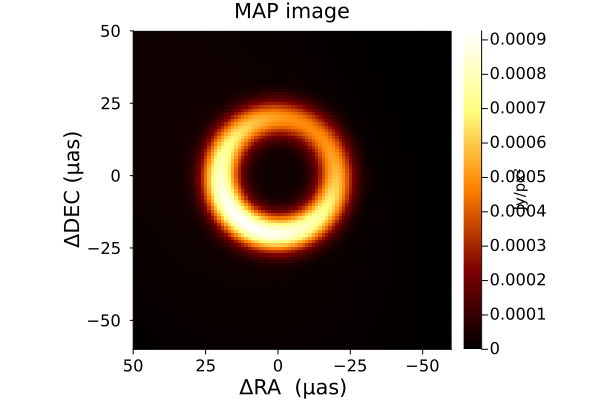

In [17]:
using Plots
Plots.plot(model(xopt), title="MAP image", xlims=(-60.0,50.0), ylims=(-60.0,50.0))

In [18]:
using ComradeAHMC, ForwardDiff
chain, stats = sample(rng, post, AHMC(metric=DiagEuclideanMetric(ndim), autodiff=Val(:ForwardDiff)), 2000; nadapts=1000, init_params=xopt)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:02:14
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.01
  n_steps:                                      63
  is_accept:                                    true
  acceptance_rate:                              0.9942028711453506
  log_density:                                  63.737399232690876
  hamiltonian_energy:                           -59.65343517009953
  hamiltonian_energy_error:                     -0.013281080613801066
  max_hami

(NamedTuple{(:radius, :width, :α, :β, :f, :σG, :τG, :ξG, :xG, :yG), NTuple{10, Float64}}[(radius = 9.979574866101982e-11, width = 2.102968393197832e-11, α = -0.14403213702881146, β = -0.09095060799453614, f = 0.6910506588223039, σG = 1.7149119530586871e-10, τG = 0.6833099824097723, ξG = 0.49644611249004394, xG = 1.2593943728936968e-10, yG = 5.101682695385793e-11), (radius = 1.0033075731678e-10, width = 2.094792794382841e-11, α = -0.14999960848590388, β = -0.09583264125611629, f = 0.69052001252113, σG = 1.7149752513604558e-10, τG = 0.6831150178610231, ξG = 0.49348007362757546, xG = 1.2614450550547544e-10, yG = 5.0113433488672275e-11), (radius = 1.00522638747376e-10, width = 2.0914516942125095e-11, α = -0.15405573541050815, β = -0.1006557444862412, f = 0.6904644174935134, σG = 1.715414765603279e-10, τG = 0.6837533159884077, ξG = 0.4944963136850446, xG = 1.2763131436362813e-10, yG = 4.9967464434329966e-11), (radius = 1.0034581356683308e-10, width = 2.0934950458659698e-11, α = -0.167663771

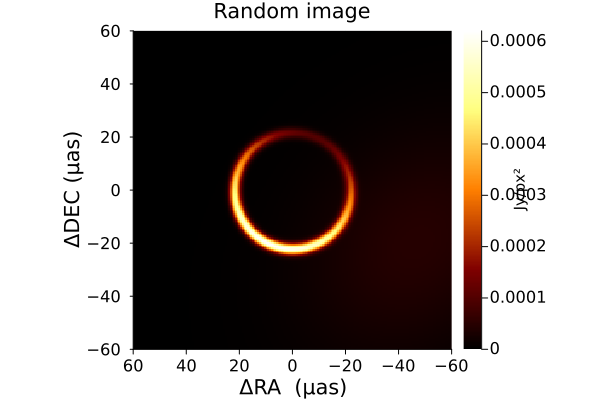

In [19]:
Plots.plot(model(chain[end]), title="Random image", xlims=(-60.0,60.0), ylims=(-60.0,60.0))

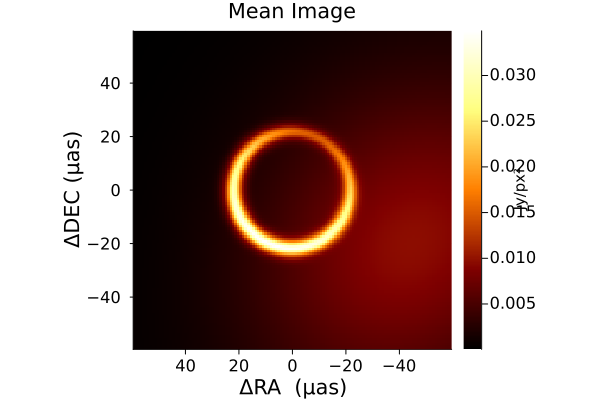

In [20]:
meanimg = mean(intensitymap.(model.(sample(chain[1000:end], 100)), μas2rad(120.0), μas2rad(120.0), 128, 128))
Plots.plot(sqrt.(max.(meanimg, 0.0)), title="Mean Image") #plot on a sqrt color scale to see the Gaussian

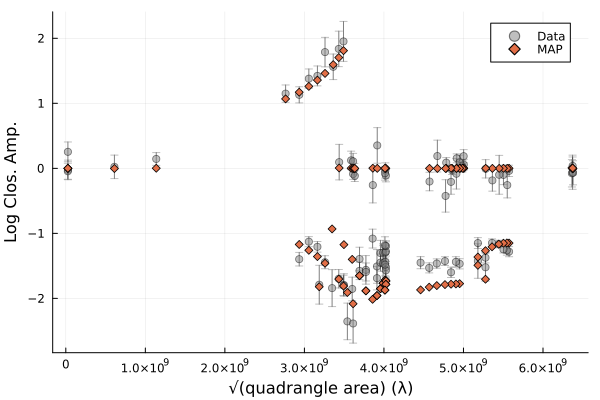

In [21]:
Plots.plot(model(xopt), dlcamp, label="MAP")